In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']  # or retina
%matplotlib inline

sns.set(context='notebook', 
    style='whitegrid', 
    font_scale=1.1)

In [2]:
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = [
181013,181020,181027,
181103,181110,181117,181124,
181201,181208,181215,181222,181229,         
190105,190112,190119,190126,
190202,190209,190216,190223,
190302,190309,190316,190323,190330,
190406,190413]
turnstiles_df = get_data(week_nums)

In [3]:
turnstiles_df.columns = [column.strip() for column in turnstiles_df.columns]
turnstiles_df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [4]:
import datetime
turnstiles_df["DATE_TIME"] = pd.to_datetime(turnstiles_df.DATE + " " + turnstiles_df.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")

In [5]:
turnstiles_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
turnstiles_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [6]:
turnstiles_daily = (turnstiles_df
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .ENTRIES.first())

In [7]:
turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])[["DATE", "ENTRIES"]]
                                                       .shift(1))

In [8]:
turnstiles_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [9]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    
    if counter < 0:
        counter = -counter  # adjust for "reverse" counter
        
    if counter > max_counter:
        # Maybe counter was reset, so it may make sense to take the minimum
        print(f'entries: {row["ENTRIES"]} <-- {row["PREV_ENTRIES"]}')
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
        
    if counter > max_counter:
        # If we still get a counter that is too big, set to zero
        return 0
    
    return counter

turnstiles_daily["DAILY_ENTRIES"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=1000000)

entries: 7653517 <-- 153545.0
entries: 416 <-- 7705439.0
entries: 15217602 <-- 323270.0
entries: 2170 <-- 15256718.0
entries: 885868970 <-- 128942.0
entries: 120 <-- 885834996.0
entries: 16737744 <-- 178223.0
entries: 197 <-- 16816011.0
entries: 1562496662 <-- 189758.0
entries: 216 <-- 1562636326.0
entries: 1662906704 <-- 281621.0
entries: 298 <-- 1663107163.0
entries: 794887 <-- 2939566.0
entries: 2536906 <-- 1091900.0
entries: 67144613 <-- 5182.0
entries: 262204 <-- 67148709.0
entries: 1554039823 <-- 748738.0
entries: 1713 <-- 1553983520.0
entries: 1279 <-- 5664363.0
entries: 5410868 <-- 60437.0
entries: 1443 <-- 7054160.0
entries: 6866806 <-- 43505.0
entries: 1261 <-- 3875856.0
entries: 3651469 <-- 45448.0
entries: 962 <-- 2117561.0
entries: 1964654 <-- 37410.0
entries: 15128327 <-- 16182842.0
entries: 235208427 <-- 68073706.0
entries: 67909068 <-- 235250907.0
entries: 644 <-- 2234841.0
entries: 2075812 <-- 12329.0
entries: 3211 <-- 5527037.0
entries: 5304252 <-- 100808.0
entries: 1

entries: 1692531 <-- 98280560.0
entries: 3974 <-- 1731421.0
entries: 98487265 <-- 15767.0
entries: 9546056 <-- 247282.0
entries: 25608 <-- 9594918.0
entries: 1464617 <-- 279238.0
entries: 30224 <-- 1502539.0
entries: 1569134037 <-- 319409.0
entries: 29831 <-- 1569166011.0
entries: 5078600 <-- 91205.0
entries: 1122 <-- 5170615.0
entries: 1152 <-- 1715604.0
entries: 1524780 <-- 10628.0
entries: 1641180 <-- 507349.0
entries: 524327 <-- 1642822.0
entries: 50331733 <-- 458763.0
entries: 1661796431 <-- 50331733.0
entries: 491291 <-- 1661802684.0
entries: 1804746 <-- 191788.0
entries: 1032 <-- 1814923.0
entries: 5586065 <-- 332753.0
entries: 1390 <-- 5602706.0
entries: 6724932 <-- 1698463.0
entries: 1377761 <-- 6741744.0
entries: 7179684 <-- 111800.0
entries: 779 <-- 7267961.0
entries: 427 <-- 14176565.0
entries: 13892241 <-- 159201.0
entries: 368 <-- 13480116.0
entries: 13210915 <-- 76778.0
entries: 1122 <-- 8296566.0
entries: 7951914 <-- 79185.0
entries: 196 <-- 2807300.0
entries: 2758184 <

In [10]:
mask = ((turnstiles_daily["STATION"] == "34 ST-PENN STA"))
#stations = ("34 ST-PENN STA" , "34 ST-HERALD SQ" , "TIMES SQ-42 ST")

station_daily = turnstiles_daily[mask].groupby(["STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()
station_daily["DATE_NEW"]= pd.to_datetime(station_daily["DATE"],format="%m/%d/%Y")
station_daily

,STATION,DATE,DAILY_ENTRIES,DATE_NEW
0,34 ST-PENN STA,01/02/2019,161139.0,2019-01-02
1,34 ST-PENN STA,01/03/2019,165817.0,2019-01-03
2,34 ST-PENN STA,01/04/2019,159750.0,2019-01-04
3,34 ST-PENN STA,01/05/2019,75019.0,2019-01-05
4,34 ST-PENN STA,01/06/2019,66389.0,2019-01-06
...,...,...,...,...
183,34 ST-PENN STA,12/27/2018,144873.0,2018-12-27
184,34 ST-PENN STA,12/28/2018,129346.0,2018-12-28
185,34 ST-PENN STA,12/29/2018,96355.0,2018-12-29
186,34 ST-PENN STA,12/30/2018,84869.0,2018-12-30


In [11]:
nba_games_data = pd.read_html('https://www.basketball-reference.com/teams/NYK/2019_games.html')[0]
nba_games_data.columns

Index(['G', 'Date', 'Start (ET)', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5',
       'Opponent', 'Unnamed: 7', 'Unnamed: 8', 'Tm', 'Opp', 'W', 'L', 'Streak',
       'Notes'],
      dtype='object')

In [12]:
nba_games_data=nba_games_data[nba_games_data["Date"]!="Date"]
nba_games_data["DATE_NEW"] = pd.to_datetime(nba_games_data["Date"],format="%a, %b %d, %Y")
mask_nba= nba_games_data[(nba_games_data['Unnamed: 5']!='@')][["DATE_NEW","Unnamed: 5"]]
mask_nba

,DATE_NEW,Unnamed: 5
0,2018-10-17,NaN
2,2018-10-20,NaN
5,2018-10-26,NaN
6,2018-10-29,NaN
7,2018-10-31,NaN
10,2018-11-05,NaN
13,2018-11-11,NaN
17,2018-11-20,NaN
19,2018-11-23,NaN
24,2018-12-01,NaN


In [13]:
station_daily["DATE_NEW"]= pd.to_datetime(station_daily["DATE"],format="%m/%d/%Y")
station_daily['DAY_OF_WEEK_NUM'] = pd.to_datetime(station_daily['DATE']).dt.dayofweek
station_daily['WEEK_OF_YEAR'] = pd.to_datetime(station_daily['DATE']).dt.isocalendar().week

In [14]:
merged_data_PENN = station_daily.merge(mask_nba)
merged_data_PENN1 = merged_data_PENN[merged_data_PENN.DAILY_ENTRIES<200000.0]
merged_data_PENN1.sort_values("DATE_NEW")

,STATION,DATE,DAILY_ENTRIES,DATE_NEW,DAY_OF_WEEK_NUM,WEEK_OF_YEAR,Unnamed: 5
25,34 ST-PENN STA,10/17/2018,179613.0,2018-10-17,2,42,NaN
26,34 ST-PENN STA,10/20/2018,97146.0,2018-10-20,5,42,NaN
27,34 ST-PENN STA,10/26/2018,174321.0,2018-10-26,4,43,NaN
28,34 ST-PENN STA,10/29/2018,176370.0,2018-10-29,0,44,NaN
30,34 ST-PENN STA,11/05/2018,182392.0,2018-11-05,0,45,NaN
31,34 ST-PENN STA,11/11/2018,85272.0,2018-11-11,6,45,NaN
32,34 ST-PENN STA,11/20/2018,183480.0,2018-11-20,1,47,NaN
33,34 ST-PENN STA,11/23/2018,118877.0,2018-11-23,4,47,NaN
34,34 ST-PENN STA,12/01/2018,102697.0,2018-12-01,5,48,NaN
35,34 ST-PENN STA,12/03/2018,179284.0,2018-12-03,0,49,NaN


In [15]:
merged_data_PENN1.columns

Index(['STATION', 'DATE', 'DAILY_ENTRIES', 'DATE_NEW', 'DAY_OF_WEEK_NUM',
       'WEEK_OF_YEAR', 'Unnamed: 5'],
      dtype='object')

In [16]:
sum_entries_nba=merged_data_PENN1.groupby(['DAY_OF_WEEK_NUM'])['DAILY_ENTRIES'].sum()
sum_entries_nba

DAY_OF_WEEK_NUM
0     971734.0
1     577613.0
2    1046774.0
3     175393.0
4     787374.0
5     591238.0
6     688718.0
Name: DAILY_ENTRIES, dtype: float64

In [17]:
sum_counts_nba=merged_data_PENN1.DAY_OF_WEEK_NUM.value_counts().sort_index()
sum_counts_nba

0    6
1    4
2    6
3    1
4    5
5    6
6    9
Name: DAY_OF_WEEK_NUM, dtype: int64

In [18]:
PENN_STATION_SUM_nba = sum_entries_nba/sum_counts_nba
PENN_STATION_SUM_nba 

DAY_OF_WEEK_NUM
0    161955.666667
1    144403.250000
2    174462.333333
3    175393.000000
4    157474.800000
5     98539.666667
6     76524.222222
dtype: float64

In [19]:
mask2 = ((turnstiles_daily["STATION"] == "34 ST-HERALD SQ"))
#stations = ("34 ST-PENN STA" , "34 ST-HERALD SQ" , "TIMES SQ-42 ST")

station_daily2 = turnstiles_daily[mask2].groupby(["STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()
station_daily2["DATE_NEW"]= pd.to_datetime(station_daily["DATE"],format="%m/%d/%Y")
station_daily2

,STATION,DATE,DAILY_ENTRIES,DATE_NEW
0,34 ST-HERALD SQ,01/02/2019,122166.0,2019-01-02
1,34 ST-HERALD SQ,01/03/2019,125025.0,2019-01-03
2,34 ST-HERALD SQ,01/04/2019,124810.0,2019-01-04
3,34 ST-HERALD SQ,01/05/2019,66214.0,2019-01-05
4,34 ST-HERALD SQ,01/06/2019,57502.0,2019-01-06
...,...,...,...,...
183,34 ST-HERALD SQ,12/27/2018,131070.0,2018-12-27
184,34 ST-HERALD SQ,12/28/2018,115238.0,2018-12-28
185,34 ST-HERALD SQ,12/29/2018,91182.0,2018-12-29
186,34 ST-HERALD SQ,12/30/2018,78691.0,2018-12-30


In [20]:
station_daily2["DATE_NEW"]= pd.to_datetime(station_daily["DATE"],format="%m/%d/%Y")
station_daily2['DAY_OF_WEEK_NUM'] = pd.to_datetime(station_daily['DATE']).dt.dayofweek
station_daily2['WEEK_OF_YEAR'] = pd.to_datetime(station_daily['DATE']).dt.isocalendar().week

In [21]:
merged_data_HERALD = station_daily2.merge(mask_nba)
merged_data_HERALD1 = merged_data_HERALD[merged_data_HERALD.DAILY_ENTRIES<200000.0]
merged_data_HERALD1.sort_values("DATE_NEW")

,STATION,DATE,DAILY_ENTRIES,DATE_NEW,DAY_OF_WEEK_NUM,WEEK_OF_YEAR,Unnamed: 5
25,34 ST-HERALD SQ,10/17/2018,137775.0,2018-10-17,2,42,NaN
26,34 ST-HERALD SQ,10/20/2018,76886.0,2018-10-20,5,42,NaN
27,34 ST-HERALD SQ,10/26/2018,138273.0,2018-10-26,4,43,NaN
28,34 ST-HERALD SQ,10/29/2018,124159.0,2018-10-29,0,44,NaN
29,34 ST-HERALD SQ,10/31/2018,133191.0,2018-10-31,2,44,NaN
30,34 ST-HERALD SQ,11/05/2018,130849.0,2018-11-05,0,45,NaN
31,34 ST-HERALD SQ,11/11/2018,65569.0,2018-11-11,6,45,NaN
32,34 ST-HERALD SQ,11/20/2018,137886.0,2018-11-20,1,47,NaN
33,34 ST-HERALD SQ,11/23/2018,119098.0,2018-11-23,4,47,NaN
34,34 ST-HERALD SQ,12/01/2018,81979.0,2018-12-01,5,48,NaN


In [22]:
sum_entries_nba2=merged_data_HERALD1.groupby(['DAY_OF_WEEK_NUM'])['DAILY_ENTRIES'].sum()
sum_entries_nba2

DAY_OF_WEEK_NUM
0    704237.0
1    426600.0
2    897318.0
3    259315.0
4    883845.0
5    479885.0
6    549124.0
Name: DAILY_ENTRIES, dtype: float64

In [23]:
sum_counts_nba2=merged_data_HERALD1.DAY_OF_WEEK_NUM.value_counts().sort_index()
sum_counts_nba2

0    6
1    4
2    7
3    2
4    7
5    6
6    9
Name: DAY_OF_WEEK_NUM, dtype: int64

In [24]:
HERALD_STATION_SUM_nba = sum_entries_nba2/sum_counts_nba2
HERALD_STATION_SUM_nba

DAY_OF_WEEK_NUM
0    117372.833333
1    106650.000000
2    128188.285714
3    129657.500000
4    126263.571429
5     79980.833333
6     61013.777778
dtype: float64

In [25]:
mask3 = ((turnstiles_daily["STATION"] == "TIMES SQ-42 ST"))
#stations = ("34 ST-PENN STA" , "34 ST-HERALD SQ" , "TIMES SQ-42 ST")

station_daily3 = turnstiles_daily[mask3].groupby(["STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()
station_daily3["DATE_NEW"]= pd.to_datetime(station_daily["DATE"],format="%m/%d/%Y")
station_daily3

,STATION,DATE,DAILY_ENTRIES,DATE_NEW
0,TIMES SQ-42 ST,01/02/2019,99037.0,2019-01-02
1,TIMES SQ-42 ST,01/03/2019,103486.0,2019-01-03
2,TIMES SQ-42 ST,01/04/2019,98222.0,2019-01-04
3,TIMES SQ-42 ST,01/05/2019,51904.0,2019-01-05
4,TIMES SQ-42 ST,01/06/2019,44810.0,2019-01-06
...,...,...,...,...
183,TIMES SQ-42 ST,12/27/2018,100980.0,2018-12-27
184,TIMES SQ-42 ST,12/28/2018,87825.0,2018-12-28
185,TIMES SQ-42 ST,12/29/2018,82445.0,2018-12-29
186,TIMES SQ-42 ST,12/30/2018,71945.0,2018-12-30


In [26]:
station_daily3["DATE_NEW"]= pd.to_datetime(station_daily["DATE"],format="%m/%d/%Y")
station_daily3['DAY_OF_WEEK_NUM'] = pd.to_datetime(station_daily['DATE']).dt.dayofweek
station_daily3['WEEK_OF_YEAR'] = pd.to_datetime(station_daily['DATE']).dt.isocalendar().week

In [27]:
merged_data_TIMES = station_daily3.merge(mask_nba)
merged_data_TIMES1 = merged_data_TIMES[merged_data_TIMES.DAILY_ENTRIES<200000.0]
merged_data_TIMES1.sort_values("DATE_NEW")

,STATION,DATE,DAILY_ENTRIES,DATE_NEW,DAY_OF_WEEK_NUM,WEEK_OF_YEAR,Unnamed: 5
25,TIMES SQ-42 ST,10/17/2018,110073.0,2018-10-17,2,42,NaN
26,TIMES SQ-42 ST,10/20/2018,69192.0,2018-10-20,5,42,NaN
27,TIMES SQ-42 ST,10/26/2018,111253.0,2018-10-26,4,43,NaN
28,TIMES SQ-42 ST,10/29/2018,97830.0,2018-10-29,0,44,NaN
29,TIMES SQ-42 ST,10/31/2018,110589.0,2018-10-31,2,44,NaN
30,TIMES SQ-42 ST,11/05/2018,100093.0,2018-11-05,0,45,NaN
31,TIMES SQ-42 ST,11/11/2018,56640.0,2018-11-11,6,45,NaN
32,TIMES SQ-42 ST,11/20/2018,105682.0,2018-11-20,1,47,NaN
33,TIMES SQ-42 ST,11/23/2018,65399.0,2018-11-23,4,47,NaN
34,TIMES SQ-42 ST,12/01/2018,77798.0,2018-12-01,5,48,NaN


In [28]:
sum_entries_nba3 = merged_data_TIMES1.groupby(['DAY_OF_WEEK_NUM'])['DAILY_ENTRIES'].sum()
sum_entries_nba3

DAY_OF_WEEK_NUM
0    537856.0
1    346539.0
2    728769.0
3    206639.0
4    656235.0
5    417100.0
6    475460.0
Name: DAILY_ENTRIES, dtype: float64

In [29]:
sum_counts_nba3=merged_data_TIMES1.DAY_OF_WEEK_NUM.value_counts().sort_index()
sum_counts_nba3

0    6
1    4
2    7
3    2
4    7
5    6
6    9
Name: DAY_OF_WEEK_NUM, dtype: int64

In [30]:
TIMES_STATION_SUM_nba = sum_entries_nba3/sum_counts_nba3
TIMES_STATION_SUM_nba

DAY_OF_WEEK_NUM
0     89642.666667
1     86634.750000
2    104109.857143
3    103319.500000
4     93747.857143
5     69516.666667
6     52828.888889
dtype: float64

In [31]:
merged_data_PENN2 = pd.merge(station_daily,merged_data_PENN, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

In [32]:
revised1=merged_data_PENN2[merged_data_PENN2.DAILY_ENTRIES<200000.0]
revised1.sort_values("DATE_NEW")

,STATION,DATE,DAILY_ENTRIES,DATE_NEW,DAY_OF_WEEK_NUM,WEEK_OF_YEAR,Unnamed: 5
102,34 ST-PENN STA,10/07/2018,99966.0,2018-10-07,6,40,NaN
103,34 ST-PENN STA,10/08/2018,144125.0,2018-10-08,0,41,NaN
104,34 ST-PENN STA,10/09/2018,181870.0,2018-10-09,1,41,NaN
105,34 ST-PENN STA,10/10/2018,180333.0,2018-10-10,2,41,NaN
106,34 ST-PENN STA,10/11/2018,176560.0,2018-10-11,3,41,NaN
...,...,...,...,...,...,...,...
93,34 ST-PENN STA,04/05/2019,174276.0,2019-04-05,4,14,NaN
94,34 ST-PENN STA,04/06/2019,94885.0,2019-04-06,5,14,NaN
97,34 ST-PENN STA,04/09/2019,177838.0,2019-04-09,1,15,NaN
99,34 ST-PENN STA,04/11/2019,180968.0,2019-04-11,3,15,NaN


In [33]:
sum_entries_not_nba1 = revised1.groupby(['DAY_OF_WEEK_NUM'])['DAILY_ENTRIES'].sum()
sum_entries_not_nba1

DAY_OF_WEEK_NUM
0    3033962.0
1    3878438.0
2    3146044.0
3    4117549.0
4    3345243.0
5    1855760.0
6    1313408.0
Name: DAILY_ENTRIES, dtype: float64

In [34]:
sum_counts_not_nba1 = revised1.DAY_OF_WEEK_NUM.value_counts().sort_index()
sum_counts_not_nba1

0    19
1    22
2    18
3    24
4    20
5    20
6    16
Name: DAY_OF_WEEK_NUM, dtype: int64

In [35]:
PENN_STATION_SUM_not_nba = sum_entries_not_nba1/sum_counts_not_nba1
PENN_STATION_SUM_not_nba

DAY_OF_WEEK_NUM
0    159682.210526
1    176292.636364
2    174780.222222
3    171564.541667
4    167262.150000
5     92788.000000
6     82088.000000
dtype: float64

In [36]:
merged_data_PENN2.describe()

,DAILY_ENTRIES,DAY_OF_WEEK_NUM,WEEK_OF_YEAR
count,1.470000e+02,147.000000,147.000000
mean,3.518569e+05,2.925170,26.102041
std,2.120765e+06,1.962276,19.693798
min,6.089000e+04,0.000000,1.000000
25%,1.089585e+05,1.000000,7.500000
50%,1.698040e+05,3.000000,15.000000
75%,1.803215e+05,5.000000,46.000000
max,2.579161e+07,6.000000,52.000000


In [37]:
merged_data_HERALD2 = pd.merge(station_daily2,merged_data_HERALD, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

In [38]:
revised2=merged_data_HERALD2[merged_data_HERALD2.DAILY_ENTRIES<200000.0]
revised2.sort_values("DATE_NEW")

,STATION,DATE,DAILY_ENTRIES,DATE_NEW,DAY_OF_WEEK_NUM,WEEK_OF_YEAR,Unnamed: 5
102,34 ST-HERALD SQ,10/07/2018,68604.0,2018-10-07,6,40,NaN
103,34 ST-HERALD SQ,10/08/2018,113139.0,2018-10-08,0,41,NaN
104,34 ST-HERALD SQ,10/09/2018,131983.0,2018-10-09,1,41,NaN
105,34 ST-HERALD SQ,10/10/2018,132357.0,2018-10-10,2,41,NaN
106,34 ST-HERALD SQ,10/11/2018,131925.0,2018-10-11,3,41,NaN
...,...,...,...,...,...,...,...
94,34 ST-HERALD SQ,04/06/2019,81953.0,2019-04-06,5,14,NaN
96,34 ST-HERALD SQ,04/08/2019,118986.0,2019-04-08,0,15,NaN
97,34 ST-HERALD SQ,04/09/2019,126306.0,2019-04-09,1,15,NaN
99,34 ST-HERALD SQ,04/11/2019,128270.0,2019-04-11,3,15,NaN


In [39]:
sum_entries_not_nba2 = revised2.groupby(['DAY_OF_WEEK_NUM'])['DAILY_ENTRIES'].sum()
sum_entries_not_nba2

DAY_OF_WEEK_NUM
0    2420326.0
1    2698923.0
2    2599312.0
3    3139868.0
4    2593638.0
5    1515918.0
6    1130008.0
Name: DAILY_ENTRIES, dtype: float64

In [40]:
sum_counts_not_nba2 = revised2.DAY_OF_WEEK_NUM.value_counts().sort_index()
sum_counts_not_nba2

0    21
1    21
2    20
3    24
4    20
5    20
6    18
Name: DAY_OF_WEEK_NUM, dtype: int64

In [41]:
HERALD_STATION_SUM_not_nba = sum_entries_not_nba2/sum_counts_not_nba2
HERALD_STATION_SUM_not_nba

DAY_OF_WEEK_NUM
0    115253.619048
1    128520.142857
2    129965.600000
3    130827.833333
4    129681.900000
5     75795.900000
6     62778.222222
dtype: float64

In [42]:
merged_data_TIMES2 = pd.merge(station_daily3,merged_data_TIMES, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

In [43]:
revised3=merged_data_TIMES2[merged_data_TIMES2.DAILY_ENTRIES<200000.0]
revised3.sort_values("DATE_NEW")

,STATION,DATE,DAILY_ENTRIES,DATE_NEW,DAY_OF_WEEK_NUM,WEEK_OF_YEAR,Unnamed: 5
102,TIMES SQ-42 ST,10/07/2018,65303.0,2018-10-07,6,40,NaN
103,TIMES SQ-42 ST,10/08/2018,87372.0,2018-10-08,0,41,NaN
104,TIMES SQ-42 ST,10/09/2018,102121.0,2018-10-09,1,41,NaN
105,TIMES SQ-42 ST,10/10/2018,110395.0,2018-10-10,2,41,NaN
106,TIMES SQ-42 ST,10/11/2018,109914.0,2018-10-11,3,41,NaN
...,...,...,...,...,...,...,...
94,TIMES SQ-42 ST,04/06/2019,72294.0,2019-04-06,5,14,NaN
96,TIMES SQ-42 ST,04/08/2019,94304.0,2019-04-08,0,15,NaN
97,TIMES SQ-42 ST,04/09/2019,105464.0,2019-04-09,1,15,NaN
99,TIMES SQ-42 ST,04/11/2019,107237.0,2019-04-11,3,15,NaN


In [44]:
sum_entries_not_nba3 = revised3.groupby(['DAY_OF_WEEK_NUM'])['DAILY_ENTRIES'].sum()
sum_entries_not_nba3

DAY_OF_WEEK_NUM
0    1810304.0
1    2221112.0
2    2085271.0
3    2573454.0
4    2063810.0
5    1300602.0
6     987518.0
Name: DAILY_ENTRIES, dtype: float64

In [45]:
sum_counts_not_nba3 = revised3.DAY_OF_WEEK_NUM.value_counts().sort_index()
sum_counts_not_nba3

0    21
1    22
2    20
3    25
4    20
5    20
6    18
Name: DAY_OF_WEEK_NUM, dtype: int64

In [46]:
TIMES_STATION_SUM_not_nba = sum_entries_not_nba3/sum_counts_not_nba3
TIMES_STATION_SUM_not_nba

DAY_OF_WEEK_NUM
0     86204.952381
1    100959.636364
2    104263.550000
3    102938.160000
4    103190.500000
5     65030.100000
6     54862.111111
dtype: float64

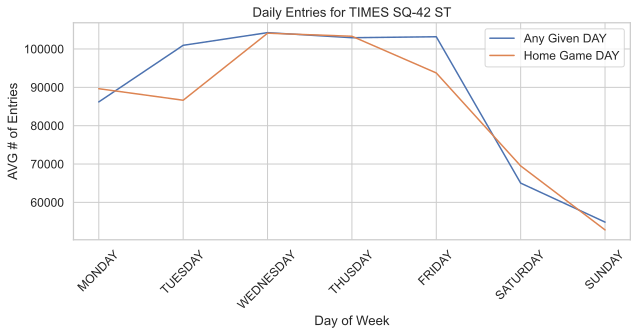

In [47]:
daysofweek = ["MONDAY","TUESDAY","WEDNESDAY","THUSDAY","FRIDAY","SATURDAY","SUNDAY"]
plt.figure(figsize=(10,4))
plt.plot(daysofweek,TIMES_STATION_SUM_not_nba,label="Any Given DAY")
plt.plot(daysofweek,TIMES_STATION_SUM_nba,label="Home Game DAY")
plt.ylabel('AVG # of Entries')
plt.xlabel('Day of Week')
plt.xticks(rotation=45)
plt.title('Daily Entries for TIMES SQ-42 ST')
plt.legend()

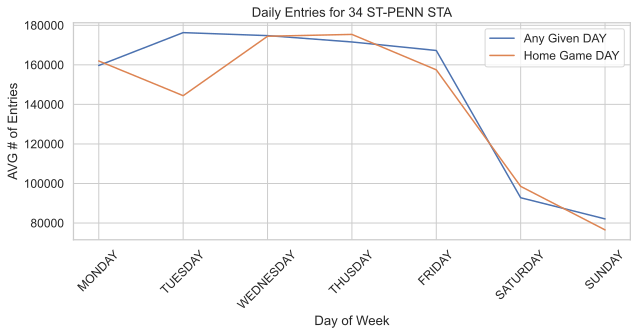

In [48]:
daysofweek = ["MONDAY","TUESDAY","WEDNESDAY","THUSDAY","FRIDAY","SATURDAY","SUNDAY"]
plt.figure(figsize=(10,4))
plt.plot(daysofweek,PENN_STATION_SUM_not_nba,label="Any Given DAY")
plt.plot(daysofweek,PENN_STATION_SUM_nba,label="Home Game DAY")
plt.ylabel('AVG # of Entries')
plt.xlabel('Day of Week')
plt.xticks(rotation=45)
plt.title('Daily Entries for 34 ST-PENN STA')
plt.legend()

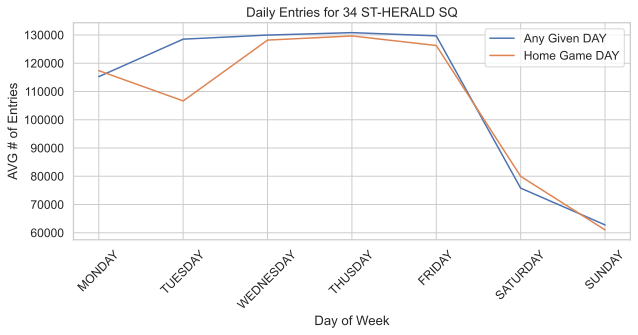

In [49]:
daysofweek = ["MONDAY","TUESDAY","WEDNESDAY","THUSDAY","FRIDAY","SATURDAY","SUNDAY"]
plt.figure(figsize=(10,4))
plt.plot(daysofweek,HERALD_STATION_SUM_not_nba,label="Any Given DAY")
plt.plot(daysofweek,HERALD_STATION_SUM_nba,label="Home Game DAY")
plt.ylabel('AVG # of Entries')
plt.xlabel('Day of Week')
plt.xticks(rotation=45)
plt.title('Daily Entries for 34 ST-HERALD SQ')
plt.legend()

**MVP METIS PROJECT 1**

For my exploratory data analysis of MTA traffic around Madison Square Garden (MSG), I gathered data on 3 stations (34 ST-HERALD SQ, 34 ST-PENN STA, TIMES SQ-42 ST) surrounding MSG. I cleaned the publicly accessible MTA data in order to get daily entries, and I also cleaned a dataframe for the knicks games schedule of the 2018-2019 season (obtained from basketball reference) such that it only contained their home games. I as able to join the tables and group by day of the week, then sum their daily entires and divide by counts of each day of the week in order to get an average daily entries on each day of the week (for the stations in question only). Additionally, was able to use various joins to get data on all the days within the 27 weeks of data I read that did not have a Knicks home game, and perform the same calculations on that data. The three graphs at the end of this jupyter notebook are the visual representation of this data. The orange lines are the days with knicks home games, and the blue lines are the days without knicks home games. The data iself reveals that my analysis was inconclusive as to the effect of knicks games on MTA traffic. I identify two possible sources of error as follows:

-The counts for the data were not large enough to generate a statistically significant result.

-The timeframe on which I joined my tables initially was not precise enough. joining on the 4 hour datatime intervals might be worth consideration.